In [1]:
%load_ext autoreload
%autoreload 2

## AGN Variablity Metric \#1
This metric examines the number of visit at each location in the WFD area to ensure reliable fitting of CARMA models to AGN light curves generated. The minimum requirement is **60** epochs over the course of 10 years, and **100** epochs would be better. 

This notebook demonstrate how to run such a metric on opsims using the MAF for u band and g band observations. Redder filters are less concerned since they have much more observations than the u and g. The summary statistics I used to compare opsims are `FracAbove_60` and `FracAbove_100`, which stand for the fraction of the WFD survey area that can be visited more 60 times and 100 times respectively. 

### 0. Software Setup

In [2]:
your_username = 'ywx649999311'

In [20]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import matplotlib as mpl

In [21]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.2,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
#     "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 20,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 20,
    "legend.fontsize": 20,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 20,              # Font size of numbers 
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
#     "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
#     "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
#         r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
#         ]
    }

mpl.rcParams.update(pgf_with_latex)

Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [5]:
# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

In [6]:
# import convenience functions
from opsimUtils import *

## 1. Test Noise Floor
### 1.1 Investigating how to determine the noise floor
Since the power spectral density of a random process is just the fourier transform of the process' autovariance function and the autocovariance function of a white noise is a delta function, we can infer that the PSD of a while noise process is just the variance of that process.

Below we try to domnstrate it using both FFT and Lomb Scargle methods. If that is the case, we can approximate the power of measurement noise in light curves using the average value of the photometric errors. 

In [146]:
# Compute the FFT based power spectrum estimates
N = 10000
var = 0.2
n = np.random.normal(0, np.sqrt(var), N)
t = np.linspace(0, 10000, N)

Mean PSD: 0.19847758555578843


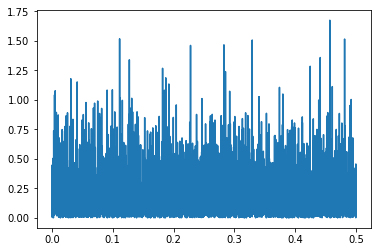

In [150]:
# FFT method
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.fft.rfft(n)
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N <<<
power_fft = fft.real/N

print(f'Mean PSD from FFT: {power_fft.mean()}')
plt.plot(f, power_fft)

Mean LS: 0.19964216463055287


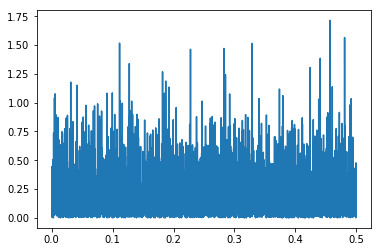

In [149]:
# LS method
from astropy.stats import LombScargle

model = LombScargle(t, n)
power_ls = model.power(f[1:], method="fast", normalization="psd")
print(f'Mean PSD from LS: {np.mean(power_ls)}')

plt.plot(f[1:], power_ls)

### 1.2 The role of noise floor in AGN variability modeling
AGN exhibits excess variability in addition to that induced by the measurement noise and the power of AGN variability is unevenly distributed across the entire frequency domain. Beyond certain timescales/frequencies, the overall variabiliy of AGN light curves will be dominated by measurement noise, knowing where that point is will set an expectation of what we can extract from the light curves. 

Where mesaurement noise dominates the PSD depends on the model used to describe AGN variability. Here we will use the Damped Random Walk (DRW) model as the baseline, but be as much model independent as possible. Next, I will start with simulating a DRW process with a decorrelation timescale of 100 days and a driving amplitude of 0.1 mag. 

The analytical PSD of a DRW process is:

$$P(f) = \frac{\sigma^{2}\tau^{2}}{1+(2\pi\tau f)^{2}}$$

where $\sigma$ is the amplitude of the driving process and $\tau$ is the decorrelation timescale. Let's plot the PSD with the parameters given above. I will show to PSDs, one without the noise power and another with both.

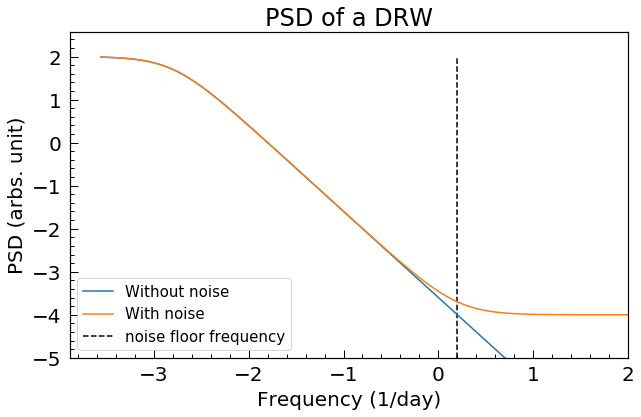

In [60]:
fig = plt.figure(figsize=(10,6))
tau = 100
sigma = 0.1

# psd of DRW
f = np.linspace(np.log10(1/3650), np.log10(1/0.001), 100)
psd = sigma**2*tau**2/(1+ (2*np.pi*tau*np.power(10, f))**2)

# psf of measurement noise assuming measurement error of 0.01 mag
psd_noise = 0.01**2

plt.plot(f, np.log10(psd), label='Without noise')
plt.plot(f, np.log10(psd+psd_noise), label='With noise')
plt.vlines(x=0.2, ymin=-5, ymax=2, linestyles='--', label='noise floor frequency')
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD (arbs. unit)')
plt.title('PSD of a DRW')
plt.ylim(bottom=-5)
plt.xlim(right=2)
plt.legend(fontsize=15, loc=3)

From the plot above, we can see that the measurement noise becomes dominate at ~5 days given the assumptions we just made. The implies that variability at timescales shorter than days is likely to be undetectable given the measurement noise level and the parameters of the DRW model. 

The next goal is to determine the timescale ($\tau_{noise}$) at which measurement noise becomes dominate for a variability of parameters of noise level. The point is __NOT__ to determine such a timescale for every possible scenario, but to figure out the best possible cadence that AGN variability modeling can take advantage of. Without the lost of generality, we will assume:

- Whatever the model is used, the turnover of the PSD at low freqency alwasy exists.
- The lowerst possible decorrelation timescale is 10 days (you will see the result should scale linearly with this $\tau$
- We will use the maximum intrinsic variance (light curve variance - noise variance) of AGN variability as determined by MacLeod et al 2010 using SDSS Stripe 82 quasars. 
- We will use a PSD of slope -2 as a steeper PSD will only shift the intersection to a lower frequency, thus a longer timescale. 
- We will use the analytic relation between the intrinsic variance and the PSD from the DRW models to predict $\tau_{noise}$

Speaking of the intrinsic variance of a DRW model, it can be determined using:

$$\sigma_{DRW}^{2} = \frac{\sigma^{2}\tau}{2}$$

The maximum PSD of a DRW occurs when $f \to 0$, that leads to $P_{DRW} = \sigma^{2}\tau^{2} = 2\sigma_{DRW}^{2}\tau$. When the PSD of noise is small compared to the PSD of the DRW process is small at the lowest frequency, we neglect the contribution of power from the measurement noise. Thus we can compute the absolute difference between the PSD plateau and the noise floor in the log scale as:

$$log_{10}(2\sigma_{DRW}^{2}\tau) - log_{10}(\sigma_{noise}^{2})$$

where $\sigma_{noise}$ is the value of the measurement error. Given a slope of -2 and a hypothetical decorrelation timescale $\tau$, we can find the $\tau_{noise}$ as:

$$\Delta log(PSD) = 2(\Delta log(f)) $$

$$\Rightarrow log_{10}(2\sigma_{DRW}^{2}\tau) - log_{10}(\sigma_{noise}^{2}) = 2*[log_{10}(f_{noise}) - log_{10}(f_{decorr})]$$

$$\Rightarrow log_{10}(\frac{2\sigma_{DRW}^{2}\tau}{\sigma_{noise}^{2}}) = \
            2*log_{10}(\frac{f_{noise}}{f_{decorr}}) =  log_{10}((\frac{2\pi\tau}{\tau_{noise}})^{2})$$
                                                            
                                                               
$$\Rightarrow \tau_{noise}^{2} = \frac{2\pi^{2}\sigma_{noise}^{2}\tau}{\sigma_{DRW}^{2}}$$

Since $\sigma_{DRW}^{2} < 1/2$ (derived from MacLeod et al. 2010), we get:

$$\tau_{noise}^{2} > \sigma_{noise}^{2}\tau*4\pi^{2} \Rightarrow \tau_{noise} > 6.2832*\sigma_{noise}\sqrt{\tau}$$

If we assume $\tau > 10$ days, then we get:

$$\tau_{noise} > 19.87*\sigma_{noise}$$

For an average photometric error of 0.02 mag, this corresponds to a $\tau_{noise}$ of ~0.4 days. Next we will use the computed photometric errors from simulated survey operations to determine the distribution of $\tau_{noise}$ across the WFD survey. The following work will rely the result produced in [05_YuPhotoErr.ipynb](./05_YuPhotoErr.ipynb) notebook.

---

In [8]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
# outDir = f'/home/idies/workspace/Storage/{your_username}/persistent/MAFOutput/YuVarMetric/'
# metricDataPath = f'/home/idies/workspace/Storage/{your_username}/persistent/MAFOutput/YuVarMetric/MetricData/'
outDir = '../tmp/VarMetric/ResultDBs/'
metricDataPath = '../tmp/VarMetric/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

In [9]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

You can also check what OpSims are available in the directory. We suggest saving the returned list of the `show_opsims` to a variable, which will make your life easier if you don't want to run metric evaluations on all avaiable opsims. 